# Twitter Sentiment Analysis and Topic modeling

In [1]:
# importing libraries

import pandas as pd
import seaborn as sns
sns.color_palette("viridis", as_cmap=True)
import numpy as np

import re, nltk
import string
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')

from sklearn import model_selection, naive_bayes, svm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP.DESKTOP-
[nltk_data]     G8GFKGS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP.DESKTOP-
[nltk_data]     G8GFKGS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('Tweets.csv')
print(df.shape)
df.sample(10)

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
6608,567760115579621376,negative,1.0000,Flight Booking Problems,1.0000,Southwest,NaN,sahandmirza,NaN,0,"@SouthwestAir was earlier, for reFlight Bookin...",NaN,2015-02-17 10:58:54 -0800,"San Francisco, CA",NaN
5826,568570374335524865,positive,1.0000,NaN,NaN,Southwest,NaN,AMiltx3,NaN,0,“@SouthwestAir: @AMiltx3 You are forgiven most...,NaN,2015-02-19 16:38:35 -0800,NaN,Central Time (US & Canada)
9527,569891260405665792,negative,1.0000,Lost Luggage,0.6555,US Airways,NaN,CatieKriewald,NaN,0,@USAirways if you DM me we can take this offli...,NaN,2015-02-23 08:07:19 -0800,"Stillwater, MN",Central Time (US & Canada)
4917,569649779090833408,negative,1.0000,Can't Tell,0.6714,Southwest,NaN,CheyHoProblems,NaN,0,@SouthwestAir I'm gonna ignore the fasten seat...,NaN,2015-02-22 16:07:45 -0800,NaN,Mountain Time (US & Canada)
9271,570013535696232449,negative,1.0000,Flight Attendant Complaints,1.0000,US Airways,NaN,jasemccarty,NaN,0,@USAirways and yet the Flight Attendant argued...,NaN,2015-02-23 16:13:11 -0800,BTR/DCA/IAD/MSY - etc,Central Time (US & Canada)
4584,569995730951147523,negative,0.6437,Can't Tell,0.3319,Southwest,NaN,djplays,NaN,0,@SouthwestAir been all up and down the area wh...,NaN,2015-02-23 15:02:26 -0800,NaN,NaN
1910,569525690950815745,negative,1.0000,Customer Service Issue,0.3725,United,NaN,ATL_Attorney,NaN,0,@united Please follow FAA guidelines regarding...,NaN,2015-02-22 07:54:40 -0800,"Atlanta, GA",Quito
2375,569239939776274433,neutral,0.6316,NaN,0.0000,United,NaN,nyc2theworld,NaN,0,@united since UA 1226 ORD-EWR is delayed pushi...,NaN,2015-02-21 12:59:12 -0800,One of the C-gates at EWR.,Eastern Time (US & Canada)
6407,567876860647833600,neutral,1.0000,NaN,NaN,Southwest,NaN,skibowlruler,NaN,0,"@SouthwestAir can u better define the ""plus on...",NaN,2015-02-17 18:42:48 -0800,washington,Pacific Time (US & Canada)
13916,569691389958553600,negative,1.0000,Lost Luggage,1.0000,American,NaN,cbratch67,NaN,0,@AmericanAir because you won't get our bags fo...,NaN,2015-02-22 18:53:06 -0800,NaN,NaN


In [3]:
print(df['text'][42])
print()
print(df['text'][222])

@VirginAmerica plz help me win my bid upgrade for my flight 2/27 LAX---&gt;SEA!!!  🍷👍💺✈️

@VirginAmerica when are you putting some great deals from PDX to LAS or from LAS to PDX show me your love! http://t.co/enIQg0buzj


In [4]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [5]:
# Unique values of sentiment
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [6]:
df.shape

(14640, 15)

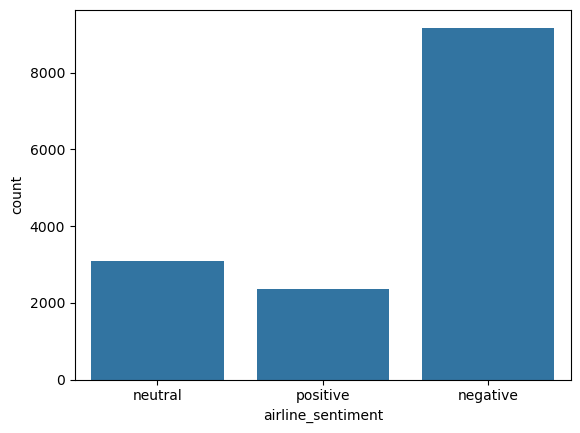

In [7]:
# Unique values of sentiment plot

ax = sns.countplot(x="airline_sentiment", data=df)

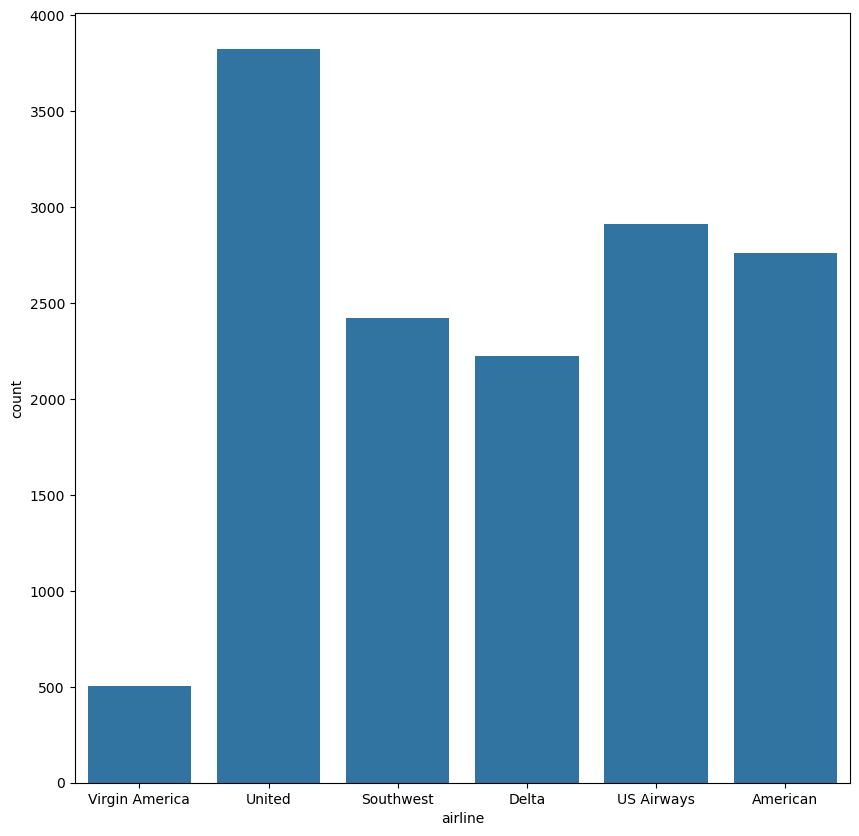

In [8]:
# Unique values of airline

plt.figure(figsize=(10,10))
ax = sns.countplot(x="airline", data=df)

### Text cleaning

In [9]:
stop_words = stopwords.words('english')
stop_words.extend(['get','hour','http','co'])

def clean_text(text):
    text = text.lower()  
    text = re.sub("&[a-z]*;", " ",text)                                           # html tags such as &gt; 
    text = re.sub("@[a-z]*", " ",text)
    text = re.sub("[^a-zA-Z]", " ",text)                                          # keep only letters
                                                                                   # lower case                                              
      # Remove stop_word
    words = word_tokenize(text)
    new_text = ""
    for i,w in enumerate(words):
        #if i == 0:                                                                  # first token is always airline name
        #    continue
        if w == 'flightled':
            w = 'flight'
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text
  #return ' '.join([word for word in text.split() if word.lower() not in stopwords.words('english')])                             

from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

from nltk import word_tokenize, pos_tag

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def lemmatize_tag(text):
    lemma=[]
    for i,j in pos_tag(word_tokenize(text)) :
        p=j[0].lower()
        lm = ''
        if p in ['j','n','v']:
            if p == 'j':
                p = 'a'
            lm = wnl.lemmatize(i,p)
        else :
            lm = wnl.lemmatize(i)
        if len(lm) > 1:
            lemma.append(lm)
    return ' '.join(lemma)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP.DESKTOP-
[nltk_data]     G8GFKGS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP.DESKTOP-
[nltk_data]     G8GFKGS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
import nltk
nltk.download('omw-1.4')

i = 5

print("BEFORE:        "+df['text'][i])
print("CLEAN:         "+clean_text(df['text'][i]))
print("CLEAN & LEMM:  "+lemmatize_tag(clean_text(df['text'][i])))

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP.DESKTOP-
[nltk_data]     G8GFKGS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BEFORE:        @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
CLEAN:          seriously would pay flight seats playing really bad thing flying va
CLEAN & LEMM:  seriously would pay flight seat play really bad thing fly va


In [11]:
print(df.shape)

# removing neutral tweets
df = df[df['airline_sentiment']!='neutral']
print(df.shape)

# positive negative codification
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: 1 if x =='positive' else 0)

# removing neutral tweets
df['cleaned_tweet'] = df['text'].apply(clean_text)
df['cleaned_tweet'] = df['cleaned_tweet'].apply(lemmatize_tag)

# remove rows with empty clean tweets
df = df[df['cleaned_tweet'].apply(len)>0]

print(df.shape)
df.head()


(14640, 15)
(11541, 15)
(11528, 16)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus added commercial experience tacky
3,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious entertainmen...
4,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),really big bad thing
5,570300767074181121,0,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),seriously would pay flight seat play really ba...
6,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),yes nearly every time fly vx ear worm go away


In [12]:
df['airline_sentiment'].unique()

array([1, 0], dtype=int64)

# Custom sentiment model

In [13]:
def check_scores(clf, X_train, X_test, y_train, y_test):

    model=clf.fit(X_train, y_train)
    predicted_class=model.predict(X_test)
    predicted_class_train=model.predict(X_train)
    test_probs = model.predict_proba(X_test)
    test_probs = test_probs[:, 1]

    print('Train confusion matrix is: ',)
    print(confusion_matrix(y_train, predicted_class_train))

    print()
    print('Test confusion matrix is: ')
    print(confusion_matrix(y_test, predicted_class))
    print()
    print(classification_report(y_test,predicted_class)) 
    print() 
    train_accuracy = accuracy_score(y_train,predicted_class_train)
    test_accuracy = accuracy_score(y_test,predicted_class)

    print()
    print("Train f1: ", f1_score(y_train, predicted_class_train))
    print("Test f1: ", f1_score(y_test, predicted_class))
    print()
    print("Train accuracy score: ", train_accuracy)
    print("Test accuracy score: ",test_accuracy )
    print()
    train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
    test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

    print("Train ROC-AUC score: ", train_auc)
    print("Test ROC-AUC score: ", test_auc)

    fig, ax1 = plt.subplots(1,1)

    plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    fpr, tpr, _ = roc_curve(y_test, test_probs)
    ax1.plot(fpr, tpr)
    ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

    return train_accuracy, test_accuracy, train_auc, test_auc



def grid_search(model, parameters, X_train, Y_train):
    #Doing a grid
    grid = GridSearchCV(estimator=model,
                      param_grid = parameters,
                      cv=3, scoring = 'f1', verbose=0, n_jobs=-1)
    #Fitting the grid 
    grid.fit(X_train,Y_train)
    # Best model found using grid search
    optimal_model = grid.best_estimator_
    print('Best parameters are: ')
    print( grid.best_params_)

    return optimal_model




### SVM

In [14]:
# Creating object of TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_tf_idf= vectorizer.fit_transform(df.cleaned_tweet)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df['airline_sentiment'], random_state=42)


In [15]:
# Tuning the hyperparameters
parameters ={
    "C":[0.1,0.3,1,3,10],
    "kernel":['linear']} 

svm_optimal = grid_search(svm.SVC(probability=True), parameters,x_train, y_train)

Best parameters are: 
{'C': 3, 'kernel': 'linear'}


Train confusion matrix is: 
[[6837   41]
 [ 102 1666]]

Test confusion matrix is: 
[[2207   83]
 [ 172  420]]

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      2290
           1       0.83      0.71      0.77       592

    accuracy                           0.91      2882
   macro avg       0.88      0.84      0.86      2882
weighted avg       0.91      0.91      0.91      2882



Train f1:  0.9588489208633093
Test f1:  0.7671232876712328

Train accuracy score:  0.9834605597964376
Test accuracy score:  0.9115197779319917

Train ROC-AUC score:  0.9945012476661769
Test ROC-AUC score:  0.9450541425705181


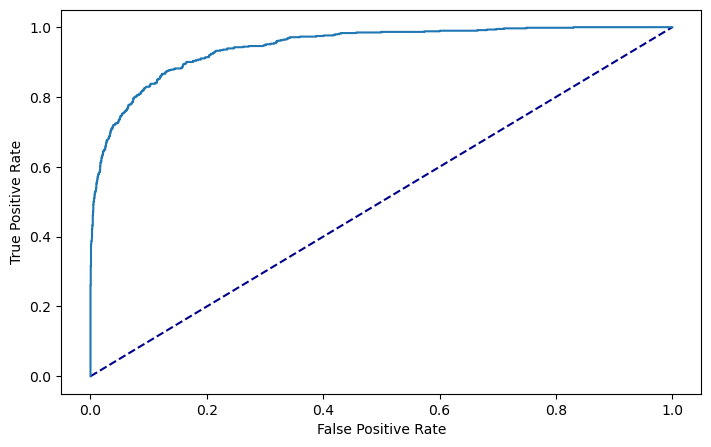

In [16]:
so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc = check_scores(svm_optimal,x_train, x_test, y_train, y_test)

### Using Multinomial Naive Bayes

Train confusion matrix is: 
[[6874    4]
 [1132  636]]

Test confusion matrix is: 
[[2286    4]
 [ 463  129]]

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2290
           1       0.97      0.22      0.36       592

    accuracy                           0.84      2882
   macro avg       0.90      0.61      0.63      2882
weighted avg       0.86      0.84      0.79      2882



Train f1:  0.5282392026578073
Test f1:  0.35586206896551725

Train accuracy score:  0.8686097617395327
Test accuracy score:  0.8379597501734907

Train ROC-AUC score:  0.964687272620816
Test ROC-AUC score:  0.9192921633423816


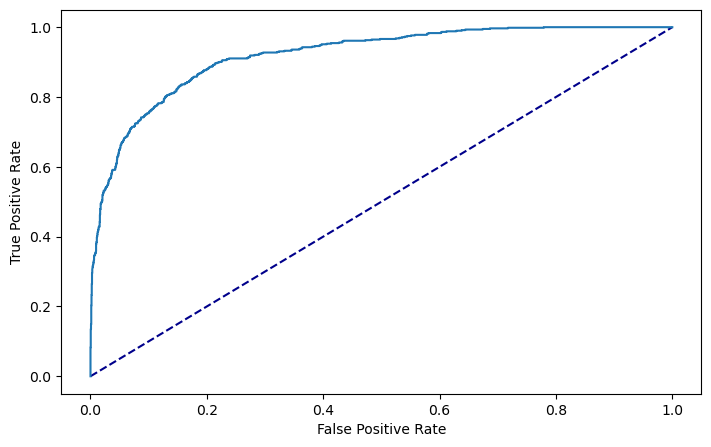

In [17]:
m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc = check_scores(MultinomialNB(),x_train, x_test, y_train, y_test)


### Adaboost

In [18]:
params = {'n_estimators': [100, 200, 500],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]}

ada_optimal_model = grid_search(AdaBoostClassifier(), params,x_train, y_train)

c:\Users\HP.DESKTOP-G8GFKGS\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters are: 
{'learning_rate': 1.0, 'n_estimators': 200}


c:\Users\HP.DESKTOP-G8GFKGS\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Train confusion matrix is: 
[[6730  148]
 [ 481 1287]]

Test confusion matrix is: 
[[2195   95]
 [ 233  359]]

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2290
           1       0.79      0.61      0.69       592

    accuracy                           0.89      2882
   macro avg       0.85      0.78      0.81      2882
weighted avg       0.88      0.89      0.88      2882



Train f1:  0.803621604745551
Test f1:  0.6864244741873805

Train accuracy score:  0.9272495951885265
Test accuracy score:  0.8861901457321305

Train ROC-AUC score:  0.9685466744910325
Test ROC-AUC score:  0.9003219786380268


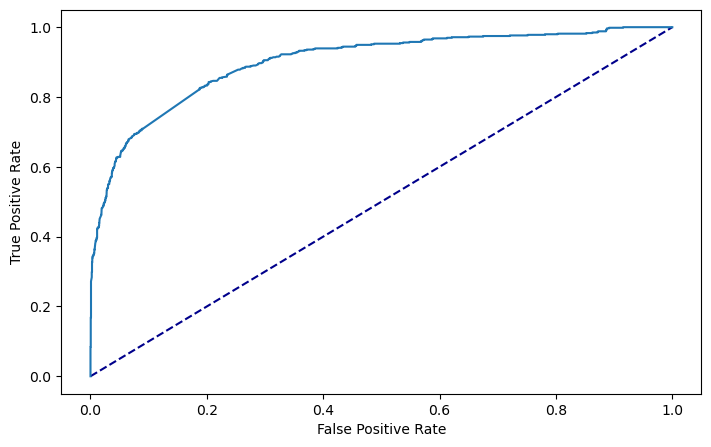

In [19]:
ao_train_accuracy, ao_test_accuracy, ao_train_auc, ao_test_auc=check_scores(ada_optimal_model,x_train,x_test, y_train, y_test)


### Random Forest

Train confusion matrix is: 
[[6878    0]
 [ 310 1458]]

Test confusion matrix is: 
[[2163  127]
 [ 224  368]]

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2290
           1       0.74      0.62      0.68       592

    accuracy                           0.88      2882
   macro avg       0.82      0.78      0.80      2882
weighted avg       0.87      0.88      0.87      2882



Train f1:  0.9039057656540608
Test f1:  0.6770929162833487

Train accuracy score:  0.964145269488781
Test accuracy score:  0.8782095766828591

Train ROC-AUC score:  0.996342813469137
Test ROC-AUC score:  0.8928666794523782


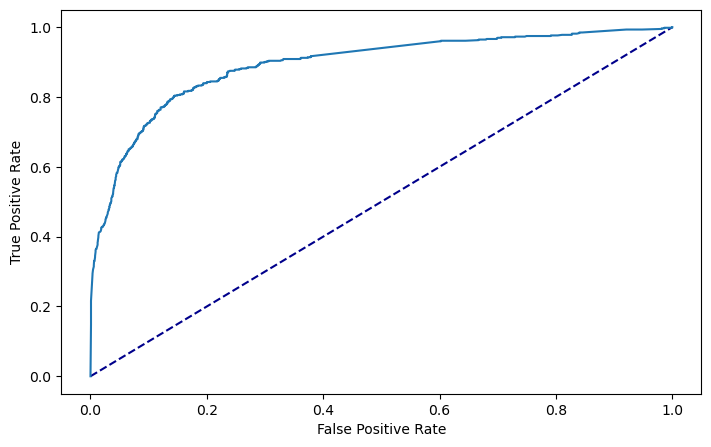

In [20]:
r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc= check_scores(RandomForestClassifier(random_state=0,max_features=0.3, max_depth=100).fit(x_train, y_train), x_train,x_test,y_train,y_test)


Final Results

In [22]:
data = [('SVM', so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc),
('MultinomialNB',m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc  ),
('Random Forest', r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc),
('AdaBoost',ao_train_accuracy, ao_test_accuracy, ao_train_auc, ao_test_auc)]

Scores_ = pd.DataFrame(data = data, columns=['Model Name','Train Accuracy', 'Test Accuracy', 'Train AUC', 'Test AUC'])
Scores_.set_index('Model Name', inplace = True)

Scores_

,Train Accuracy,Test Accuracy,Train AUC,Test AUC
Model Name,,,,
SVM,0.983461,0.91152,0.994501,0.945054
MultinomialNB,0.868610,0.83796,0.964687,0.919292
Random Forest,0.964145,0.87821,0.996343,0.892867
AdaBoost,0.927250,0.88619,0.968547,0.900322


# Topic modeling
Why do people have a bad sentiment?

In [23]:
df_neg = df[df['airline_sentiment']==0]
df_neg.shape

(9168, 16)

In [24]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import LsiModel
from gensim.models import TfidfModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim import matutils, models
from gensim.corpora import Dictionary
import scipy.sparse

def prepare_corpus(doc_clean):
  # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
  #dictionary = corpora.Dictionary(doc_clean)
  # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
  #corpus = [dictionary.doc2bow(doc) for doc in doc_clean]
  #tfidf = TfidfModel(corpus) ##ngram_range=(1,1),min_df=3
  #corpus_tfidf = tfidf[corpus]

    cv = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=3)
    data_cv = cv.fit_transform(df_neg.cleaned_tweet)
    data = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
    data.index = df_neg.index
    tdm = data.transpose()
    sparse_counts = scipy.sparse.csr_matrix(tdm)
    corpus = matutils.Sparse2Corpus(sparse_counts)

    #d = corpora.Dictionary()
    id2word = dict((v, k) for k, v in cv.vocabulary_.items())
    #d.id2token = dict((v, k) for k, v in cv.vocabulary_.items())
    #d.id2token = id2word

    gensim_dict = Dictionary.from_corpus(corpus, id2word=id2word)

    return gensim_dict,corpus

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

print(df_neg['cleaned_tweet'].iloc[0])
dictionary, corpus = prepare_corpus(df_neg.cleaned_tweet.apply(word_tokenize))
print(corpus[0])
print(len(dictionary))


really aggressive blast obnoxious entertainment guest face little recourse
[(51, 0.4093394376239241), (245, 0.39888522759741285), (740, 0.33393774278612887), (805, 0.33887385208752413), (998, 0.39888522759741285), (1304, 0.2959458996553709), (1808, 0.21890736734368618), (1825, 0.39034351605854517)]
2560


In [26]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LDA topic models
              c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate model
        model = LsiModel(corpus, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        c_v.append(coherencemodel.get_coherence())
    return model_list, c_v

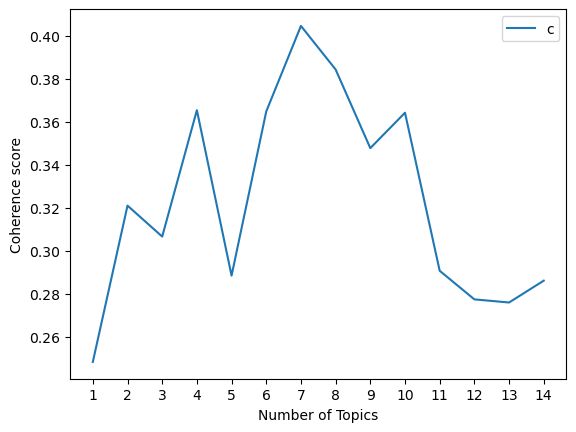

In [27]:
def plot_graph(doc_clean, start, stop, step):
    dictionary,corpus=prepare_corpus(doc_clean)
    model_list,c_v = compute_coherence_values(dictionary, corpus, doc_clean,
                                                            stop, start, step)
  

    # cv
    x = range(start, stop, step)
    fig = plt.plot(x, c_v, label = 'cv')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(('cv'), loc='best')
    plt.xticks(ticks = x)
    plt.show()
    plt.close()

    return model_list

model_list = plot_graph(df_neg.cleaned_tweet.apply(word_tokenize),1,15,1)

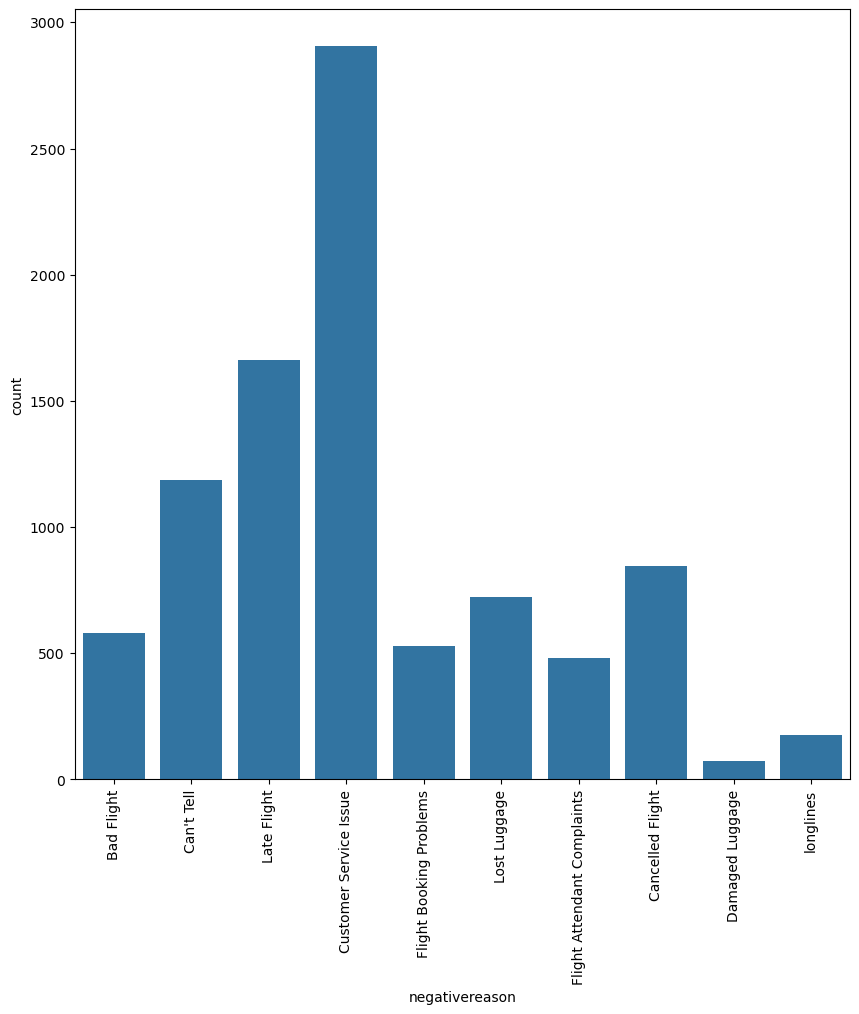

In [28]:
# Unique values of airline

plt.figure(figsize=(10,10))
ax = sns.countplot(x="negativereason", data=df_neg)
ax.tick_params(axis='x', rotation=90)

In [29]:
ntopic = 6
model = model_list[ntopic-1]
model.show_topics()

[(0,
  '0.678*"flight" + 0.253*"cancel" + 0.161*"delay" + 0.157*"hold" + 0.138*"help" + 0.126*"time" + 0.124*"call" + 0.122*"wait" + 0.112*"service" + 0.109*"customer"'),
 (1,
  '0.507*"flight" + -0.368*"customer" + -0.367*"service" + 0.253*"cancel" + -0.227*"call" + -0.161*"wait" + -0.158*"hold" + -0.119*"bag" + -0.115*"time" + -0.111*"still"'),
 (2,
  '-0.468*"customer" + -0.465*"service" + 0.342*"hold" + 0.267*"call" + 0.192*"wait" + 0.168*"help" + -0.164*"bad" + 0.160*"minute" + -0.152*"flight" + -0.134*"ever"'),
 (3,
  '-0.374*"delay" + 0.368*"hold" + -0.288*"plane" + 0.224*"cancel" + 0.220*"call" + -0.218*"bag" + 0.215*"customer" + 0.205*"service" + 0.191*"help" + -0.185*"gate"'),
 (4,
  '0.448*"hold" + -0.341*"call" + 0.313*"wait" + 0.291*"minute" + 0.262*"delay" + -0.158*"bag" + 0.157*"min" + -0.146*"back" + 0.143*"service" + -0.135*"say"'),
 (5,
  '-0.328*"bad" + -0.307*"hold" + 0.303*"call" + -0.282*"airline" + -0.279*"fly" + 0.238*"wait" + -0.228*"ever" + -0.199*"help" + -0.

In [30]:
list_guess = ['Flight Cancelled',   # 0
              'Flight Customer Service',   # 1
              'CS booking',   # 2
              'Flight Delay',   # 3
              'CS booking',   # 4
              'flight experience']   # 5]

In [31]:
lst = []
for topic in model.show_topics(formatted=False):
    tuples = topic[1]
    for tup in tuples:
        lst.append(tup[0])

counter=pd.DataFrame(lst).value_counts()
print(counter.head(10))
#plt.show()
print('\n')

0       
call        6
hold        6
wait        5
service     5
help        4
customer    4
bag         3
cancel      3
delay       3
flight      3
Name: count, dtype: int64




### Find the most dominant topic in each document

In [32]:
corpus_transformed = model[corpus]
len(corpus_transformed)

9168

In [33]:
j=list(corpus_transformed)[0]
j[0][1]

0.013465358821693698

In [34]:
from pandas.core.common import not_none
topic_prediction=[]
for j in list(corpus_transformed):
    if len(j) > 0:
        main_topic=j[0][0]
        weigth=np.abs(j[0][1])
        for t,w in j:
            if np.abs(w) > weigth :
                main_topic=t
                weigth=np.abs(w)
    topic_prediction.append(main_topic)

In [35]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(list(df_neg.negativereason))

print(le.classes_)

enc_negativereason=le.transform(list(df_neg.negativereason))

['Bad Flight' "Can't Tell" 'Cancelled Flight' 'Customer Service Issue'
 'Damaged Luggage' 'Flight Attendant Complaints' 'Flight Booking Problems'
 'Late Flight' 'Lost Luggage' 'longlines']


In [36]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(enc_negativereason,topic_prediction,normalize='pred')
print(cm)

[[0.07257518 0.01569714 0.01889764 0.10088781 0.04588015 0.07777778
  0.         0.         0.         0.        ]
 [0.10354963 0.12742382 0.06614173 0.10169492 0.14981273 0.3625
  0.         0.         0.         0.        ]
 [0.17522044 0.00554017 0.01102362 0.01452785 0.01872659 0.02916667
  0.         0.         0.         0.        ]
 [0.22156907 0.61957525 0.78110236 0.08797417 0.43726592 0.25416667
  0.         0.         0.         0.        ]
 [0.00520009 0.00923361 0.0015748  0.01533495 0.01310861 0.00972222
  0.         0.         0.         0.        ]
 [0.05652272 0.04893813 0.02992126 0.07667474 0.02996255 0.04444444
  0.         0.         0.         0.        ]
 [0.08139272 0.02400739 0.03464567 0.00968523 0.06741573 0.05138889
  0.         0.         0.         0.        ]
 [0.21184716 0.04339797 0.03149606 0.385795   0.08707865 0.12361111
  0.         0.         0.         0.        ]
 [0.0569749  0.07479224 0.01732283 0.17029863 0.1329588  0.0375
  0.         0.     

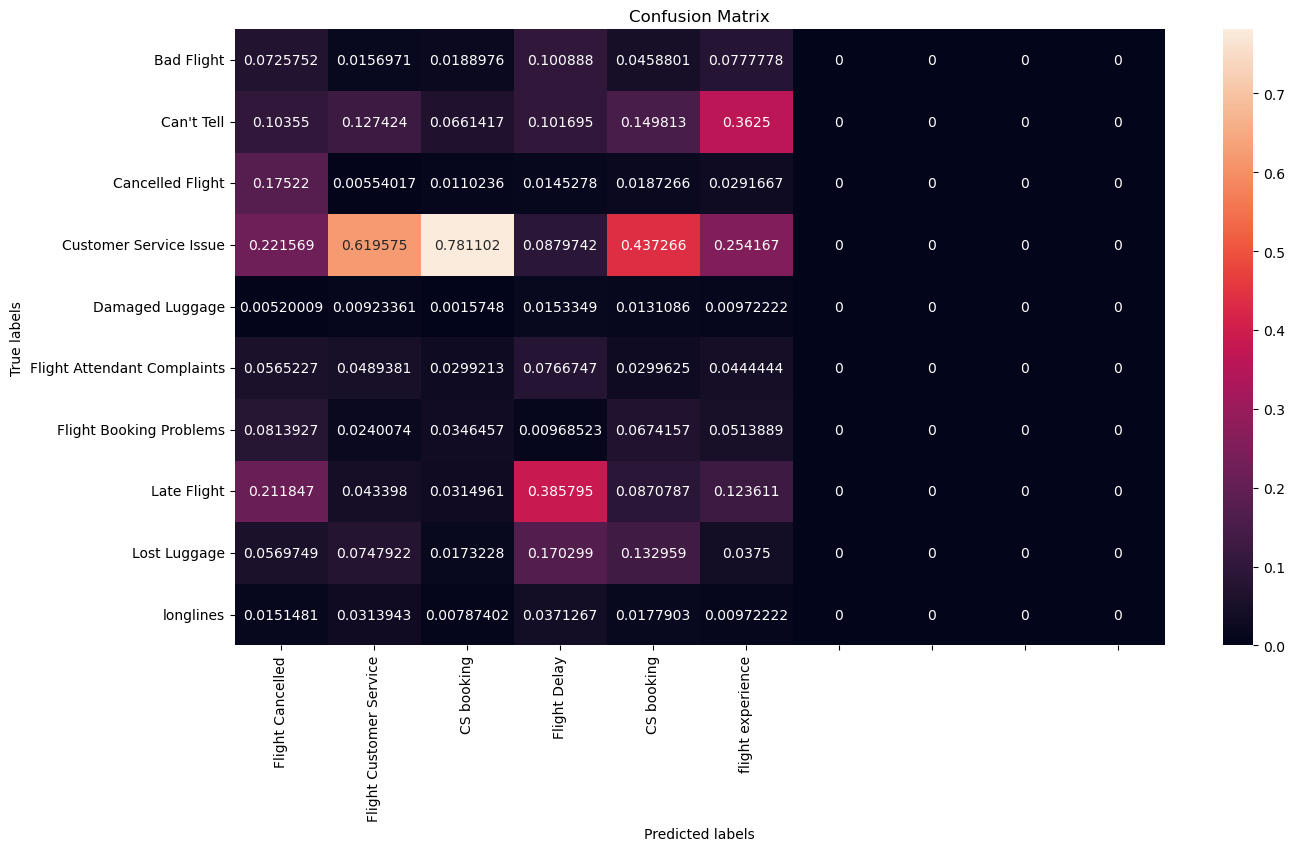

In [37]:
plt.figure(figsize = (15,8))

ax=sns.heatmap(cm, annot=True, fmt='g');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.yaxis.set_ticklabels(['Bad Flight', "Can't Tell", 'Cancelled Flight', 'Customer Service Issue',
 'Damaged Luggage', 'Flight Attendant Complaints', 'Flight Booking Problems',
 'Late Flight', 'Lost Luggage', 'longlines'])
ax.tick_params(axis='y', rotation=0)
ax.xaxis.set_ticklabels(list_guess+['','','',''])
ax.tick_params(axis='x', rotation=90)
plt.show()
plt.close()
#plt.set_xticklabels(ax.get_xticklabels(),rotation = 30)